<a href="https://colab.research.google.com/github/vbravo0/socialstego-frontend-test/blob/main/comparacion_hiperparametros_epochs30.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential, layers
import matplotlib.pyplot as plt
import os
import numpy as np
from pathlib import PurePath
import shutil
import json
from google.colab import userdata, output
import subprocess
import sys
import logging
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

In [ ]:
! pip install -q efficientnet
import efficientnet as efn

! pip install -q kaggle

# Conectar TPU

No correrlo muchas veces, si no se reinicia el notebook

In [ ]:
def connect_tpu():
  # Detect hardware, return appropriate distribution strategy
  try:
      # TPU detection. No parameters necessary if TPU_NAME environment variable is
      # set: this is always the case on Kaggle.
      tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
      print('Running on TPU ', tpu.master())
  except ValueError:
      tpu = None

  if tpu:
      tf.config.experimental_connect_to_cluster(tpu)
      tf.tpu.experimental.initialize_tpu_system(tpu)
      strategy = tf.distribute.experimental.TPUStrategy(tpu)
  else:
      # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
      strategy = tf.distribute.get_strategy()

  print("REPLICAS: ", strategy.num_replicas_in_sync)
  return strategy

strategy = connect_tpu()

Running on TPU  


REPLICAS:  8


# Mount Drive
Montamos el drive para guardar los resultados de las CNN.
Recomiendo agregar un shortcut de la carpeta tpp en la raiz de cada Drive.
Asi, los datos se encuentran en
```
/content/drive/MyDrive/tpp/Colab/comparaciones/output
```

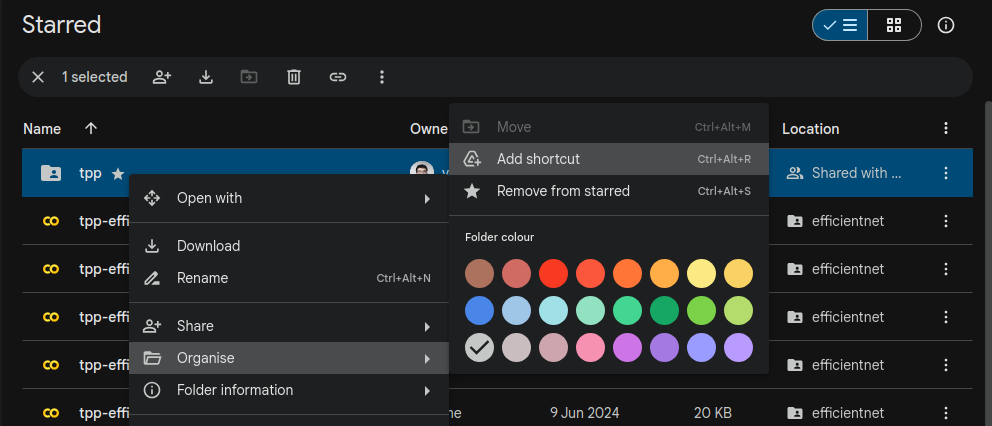

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! ls /content/drive/MyDrive/tpp/Colab/comparaciones/output

comparacion-densenet			  comparacion-hiperparametros-epochs30-LR4-DenseNet
comparacion-efnv1			  comparacion-hiperparametros-epochs30-LR4-VGG16
comparacion-efnv2			  comparacion-hiperparametros-epochs30-LR4-VGG19
comparacion-efnv2-drop			  comparacion-hiperparametros-epochs60
comparacion-efnv2-epoch-60		  comparacion-hiperparametros-LR3
comparacion-hiperparametros		  comparacion-hiperparametros-MobileNetV3Small
comparacion-hiperparametros-2		  comparacion-hiperparametros-YCrCb
comparacion-hiperparametros-3		  comparacion-mobilenet
comparacion-hiperparametros-epochs30	  comparacion-vgg
comparacion-hiperparametros-epochs30-LR4


# Constantes

In [ ]:
# kaggle dataset
DATASET_OWNER = 'vbravo'
DATASET_NAME = 'alaska-tfrecords'
DATASET_PATH = '/content/working/dataset'

# Constantes de prueba
# si IS_TEST = True, se reduce el tamaño del dataset con
# train 3 batch, val 1 batch, test 1 batch.
# si IS_TEST = False, se usa todo el dataset
IS_TEST = False

# cnn
BATCH_FACTOR = 32
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE
BUFFER_SIZE = 1_024 * 8
SEED = 111

# Output
OUTPUT_PATH = '/content/drive/MyDrive/tpp/Colab/comparaciones/output/comparacion-hiperparametros-epochs30'

# Variables

In [ ]:
dataset_fullname =  DATASET_OWNER + '/' + DATASET_NAME
dataset_zip_path = '/content/' + DATASET_NAME + '.zip'

batch_size = BATCH_FACTOR * strategy.num_replicas_in_sync
print(batch_size)

256


# Redes

Modelos que corren (o mas bien, no rompieron)
- EfficientNet V1 y V2 (hasta ahora los mejores resultados)
- VGG16
- InceptionV2
- Xception
- DenseNet121
- InceptionV3

Modelos con problemas:    
OBS: Volver a probar, parece que era porque batch no tenia "drop_remainders=True" y tal vez las ultimas imagenes sobrantes hacia que el prox epoch diera val_loss Nan  
- Dan val_loss: Nan
  - ResNet50
  - NASNetMobile

- Llena la memoria de la TPU
  - ConvNeXtTiny

## preprocessing
Los modelos con `preprocess_input=None` pueden aprovechar que el modelo se inicia con `include_preprocessing=True`, asi que no es necesario agregar preprocesamiento.   

Los que tienen una funcion si lo necesitan

In [ ]:
# NN tf.keras.applications.MobileNetV2
# PREPROCESS_UNIT = tf.keras.applications.mobilenet_v2.preprocess_input
import tensorflow as tf

CNN_MODELS = {
  "EFNV2-B0": {
    "category": "EfficientNetV2",
    "app": tf.keras.applications.EfficientNetV2B0,
    "img_size": 512,
    "preprocess_input": None, #tf.keras.applications.efficientnet_v2.preprocess_input,
    "batch_factor": 64,
    "optimizer": "adam",
    'learning_rate': 1e-3
  },
  "MobileNetV3Large": {
    "category": "MobileNetV3Large",
    "app": tf.keras.applications.MobileNetV3Large,
    "img_size": 512,
    "preprocess_input": tf.keras.applications.mobilenet_v3.preprocess_input,
    "optimizer": "adam",
    "batch_factor": 64,
    'learning_rate': 1e-3
  },
  "VGG16": {
    "category": "VGG",
    "app": tf.keras.applications.VGG16,
    "img_size": 512,
    "preprocess_input": tf.keras.applications.vgg16.preprocess_input,
    "batch_factor": 10,
    'learning_rate': 1e-4
  },
  "InceptionV3": {
    "category": "InceptionV3",
    "app": tf.keras.applications.InceptionV3,
    "img_size": 512,
    "preprocess_input": tf.keras.applications.inception_v3.preprocess_input,
    "batch_factor": 32,
    'optimizer': 'adam',
    'learning_rate': 1e-3
  },
  "ResNet50V2": {
    "category": "ResNet50V2",
    "app": tf.keras.applications.ResNet50V2,
    "img_size": 512,
    "preprocess_input": tf.keras.applications.resnet_v2.preprocess_input,
    "batch_factor": 24,
    "optimizer": "adam",
    'learning_rate': 1e-3
  }, "DenseNet121": {
    "category": "DenseNet",
    "app": tf.keras.applications.DenseNet121,
    "img_size": 512,
    "preprocess_input": tf.keras.applications.densenet.preprocess_input,
    "batch_factor": 16,
    'optimizer': 'adam',
    'learning_rate': 1e-4
  },
  "DenseNet121": {
    "category": "DenseNet",
    "app": tf.keras.applications.DenseNet121,
    "img_size": 512,
    "preprocess_input": tf.keras.applications.densenet.preprocess_input,
    "batch_factor": 16,
    'optimizer': 'adam',
    'learning_rate': 1e-4
  }
}

# Hiperparametros
- Optimizadores
  - learning rate
  - weight decay
- Preprocesamiento de imagenes
  - RGB
  - YCrCb

In [ ]:
import copy
import itertools

hyperparams_options = {
    'cnn_name': [
        'MobileNetV3Large',
        'ResNet50V2',
        'InceptionV3',
        'EFNV2-B0',
        'VGG16',
        'DenseNet121'
    ],
    'weight_decay': [1e-5],
    'channel': ['RGB']
}

import itertools
import pprint


def hyperparam_permuter(hyperparams):
  """
  Dado los hiperparametros, devuelve una lista con un diccionario con cada opcion.
  """
  sorted_keys = sorted(hyperparams.keys())

  options = []
  for key in sorted_keys:
    option = hyperparams.get(key)
    options.append(option)

  permutations = []
  for e in itertools.product(*options):
    permutation = {}
    for i, key in enumerate(sorted_keys):
      permutation[key] = e[i]
    permutations.append(permutation)

  return permutations


hyperparams = hyperparam_permuter(hyperparams_options)
pprint.pprint(hyperparams)

[{'channel': 'RGB', 'cnn_name': 'MobileNetV3Large', 'weight_decay': 1e-05},
 {'channel': 'RGB', 'cnn_name': 'ResNet50V2', 'weight_decay': 1e-05},
 {'channel': 'RGB', 'cnn_name': 'InceptionV3', 'weight_decay': 1e-05},
 {'channel': 'RGB', 'cnn_name': 'EFNV2-B0', 'weight_decay': 1e-05},
 {'channel': 'RGB', 'cnn_name': 'VGG16', 'weight_decay': 1e-05},
 {'channel': 'RGB', 'cnn_name': 'DenseNet121', 'weight_decay': 1e-05}]


# Descarga del dataset


In [ ]:
def shell_run(cmd):
  print(f'Running: {cmd}')
  with subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, shell=True) as process:
    for line in process.stdout:
      print(line.decode('utf8').strip('\n'))

def descargar_dataset(dataset_owner, dataset_name, dataset_path):
  shell_run('mkdir -p /root/.kaggle')
  KAGGLE_PATH = '/root/.kaggle/kaggle.json'
  KAGGLE_AUTH = {
    "username": userdata.get('KAGGLE_USERNAME'),
    "key": userdata.get('KAGGLE_KEY')
  }

  with open(KAGGLE_PATH, 'w+') as file:
    json.dump(KAGGLE_AUTH, file)

  dataset_fullname = dataset_owner + '/' + dataset_name
  shell_run('chmod 600 /root/.kaggle/kaggle.json')
  shell_run(f'kaggle datasets download -d {dataset_fullname}')
  shell_run(f'mkdir -p {dataset_path}')
  shell_run(f'unzip -n {dataset_name}.zip -d {dataset_path}')

In [ ]:
descargar_dataset(DATASET_OWNER, DATASET_NAME, DATASET_PATH)
output.clear()

# Creacion del dataset

In [ ]:
def image_rgb_to_ycrcb(image):
    return tf.image.rgb_to_yuv(image)

def random_rot90(image):
    # random int between 0 and 3
    rot = tf.random.uniform((),0,4, dtype=tf.int32, seed=SEED)
    return tf.image.rot90(image, k=rot)

def image_augmentation(image):
    image = tf.image.random_flip_left_right(image, seed=SEED)
    image = tf.image.random_flip_up_down(image, seed=SEED)
    image = random_rot90(image)
    return image

def parse_tfrecord_fn(example):
    feature_description = {
        "image_raw": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_jpeg(example["image_raw"], channels=3)
    return example

def to_binary_label(label):
    zero = tf.constant(0, dtype=tf.int64)
    one = tf.constant(1, dtype=tf.int64)
    label = tf.cond(tf.equal(label, zero), lambda: zero, lambda: one)
    return label

def prepare_sample(features):
    image = features["image"]
    label = features["label"]
    return image, label

def resize_image(image, img_size):
    image = tf.keras.preprocessing.image.smart_resize(image, [img_size, img_size])
    return image

def new_dataset(filenames, batch_size, img_size, preprocess_input=None, shuffle=False, binarize_label=True, augmentation=False, channel = 'RGB'):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)

    if shuffle:
      # no hacer shuffle al de validacion ni test
      dataset = dataset.shuffle(BUFFER_SIZE, seed=SEED)

    dataset = (
        dataset
          .map(parse_tfrecord_fn, num_parallel_calls=AUTOTUNE)
          .map(prepare_sample, num_parallel_calls=AUTOTUNE)
          .map(lambda x, y: (resize_image(x, img_size), y), num_parallel_calls=AUTOTUNE)
    )

    if augmentation:
      dataset = dataset.map(lambda x, y: (image_augmentation(x), y), num_parallel_calls=AUTOTUNE)

    if channel == 'YCrCb':
      dataset = dataset.map(lambda x, y: (image_rgb_to_ycrcb(x), y), num_parallel_calls=AUTOTUNE)

    if binarize_label:
      dataset = dataset.map(lambda x, y: (x, to_binary_label(y)), num_parallel_calls=AUTOTUNE)

    # if preprocess_input:
    #     dataset = dataset.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)

    dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(AUTOTUNE)
    return dataset

In [ ]:
filenames = {
    'train': tf.io.gfile.glob(f"{DATASET_PATH}/train/*.tfrecord"),
    'val': tf.io.gfile.glob(f"{DATASET_PATH}/val/*.tfrecord"),
    'test': tf.io.gfile.glob(f"{DATASET_PATH}/test/*.tfrecord")
}

# Vista previa al dataset

### En RGB

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


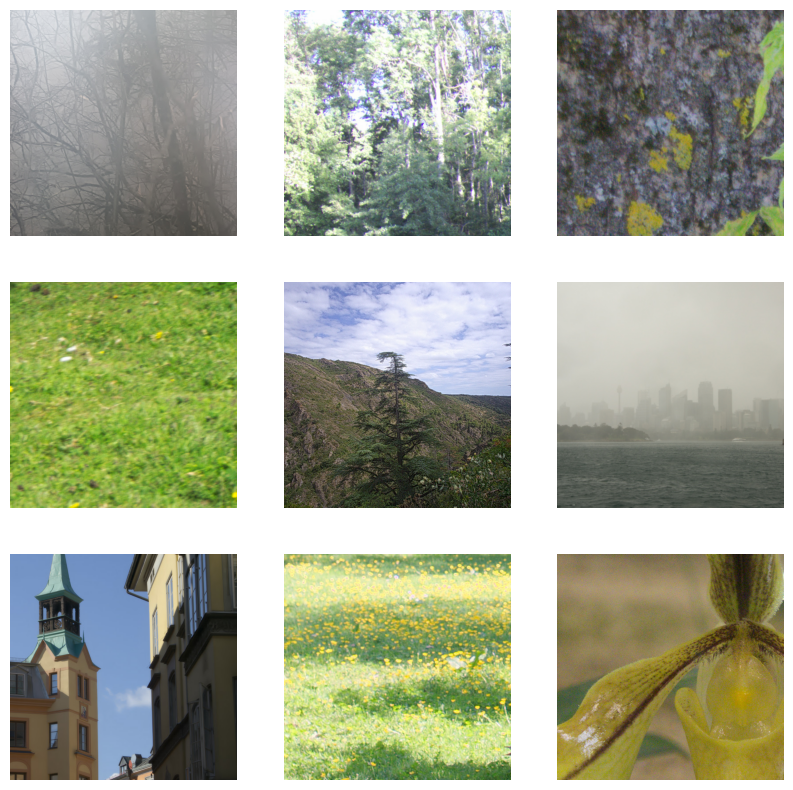

In [ ]:
valid_dataset = new_dataset(filenames['val'], batch_size, img_size=512, channel='RGB')

plt.figure(figsize=(10, 10))
for images, labels in valid_dataset.take(1):
  print(labels.numpy())
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

### En YCbCr

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


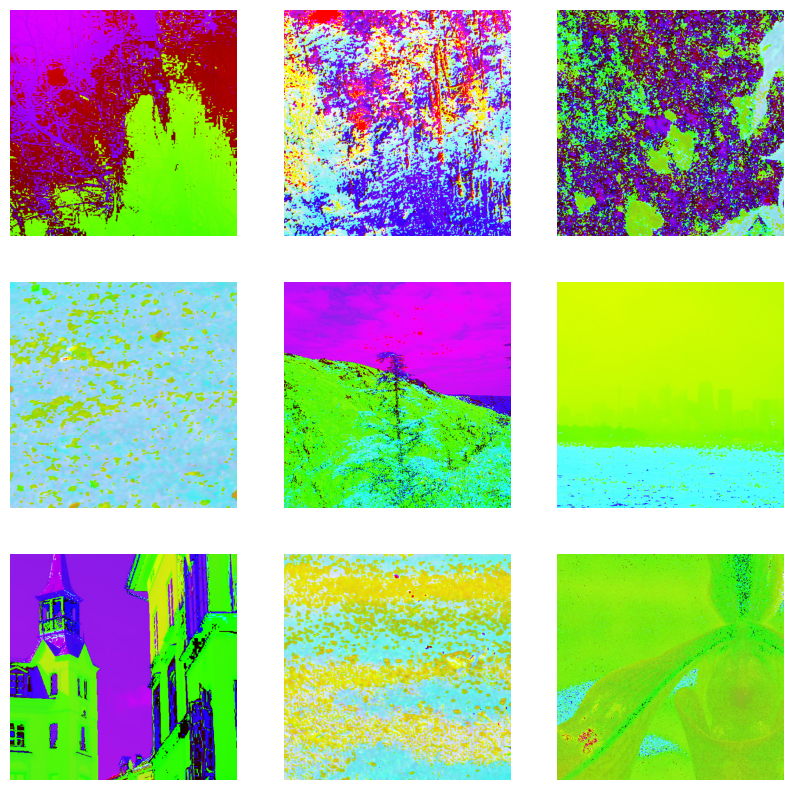

In [ ]:
valid_dataset = new_dataset(filenames['val'], batch_size, img_size=512, channel='YCrCb')

plt.figure(figsize=(10, 10))
for images, labels in valid_dataset.take(1):
  print(labels.numpy())
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

# Modelado

In [ ]:
def build_model(strategy, cnn, hyperparam):
    with strategy.scope():
      learning_rate = cnn['learning_rate']
      weight_decay = hyperparam['weight_decay']

      optimizers = {
        'rmsprop': tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
        'sgf': tf.keras.optimizers.SGD(learning_rate=learning_rate),
        'adam': tf.keras.optimizers.Adam(learning_rate=learning_rate),
        'adamw': tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
      }


      inputs = layers.Input(shape=(cnn['img_size'], cnn['img_size'], 3))

      if cnn['preprocess_input']:
        # VGG16 y 19 no tienen include_preprocessing
        model = cnn['app'](
          include_top=False,
          input_tensor=inputs,
          weights="imagenet",
        )
        # Agregamos la capa de preprocesamiento
        processed_input = cnn['preprocess_input'](inputs)
        x = model(processed_input)
      else:
        model = cnn['app'](
          include_top=False,
          input_tensor=inputs,
          weights="imagenet",
          include_preprocessing=True
        )
        x = model.output
      x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
      x = tf.keras.layers.Dropout(0.2)(x)
      outputs = layers.Dense(1, activation="sigmoid", name="pred")(x)
      model = tf.keras.Model(inputs, outputs)

      optimizer = optimizers.get(cnn.get('optimizer', 'adam'))

      model.compile(
          optimizer=optimizer,
          loss="binary_crossentropy",
          metrics=[
              tf.keras.metrics.BinaryAccuracy(name='accuracy'),
              tf.keras.metrics.AUC(name='auc')
          ]
      )
      model.summary()

    return model

# Visualizaciones

In [ ]:
def plot_hist(hist, metric):
  plt.plot(hist.history[metric])
  plt.plot(hist.history[f"val_{metric}"])
  plt.title(f"model {metric}")
  plt.ylabel(metric)
  plt.xlabel("epoch")
  plt.legend(["train", "validation"], loc="upper left")
  plt.show()

def plot_histogram(y_true, y_pred):
  data = {
    'labels': np.concatenate([y_true, y_pred]),
    'kind': ['true' for i in y_true] + ['pred' for i in y_pred]
  }
  sns.histplot(data=data, x='labels', hue='kind')
  plt.show()

def plot_auc(y_true, y_pred):
  fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
  roc_auc = metrics.auc(fpr, tpr)
  display = metrics.RocCurveDisplay(
      fpr=fpr,
      tpr=tpr,
      roc_auc=roc_auc,
      estimator_name='example estimator'
  )

  optimal_idx = np.argmax(tpr - fpr)
  optimal_threshold = thresholds[optimal_idx]
  display.plot()
  plt.show()

def y_pred_to_int(y_pred, threshold):
  y_pred_int = []
  for y in y_pred:
    if y >= threshold:
      y_pred_int.append(1)
    else:
      y_pred_int.append(0)
  return y_pred_int

def get_optimal_threshold(y_true, y_pred):
  fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
  optimal_idx = np.argmax(tpr - fpr)
  optimal_threshold = thresholds[optimal_idx]
  print(optimal_threshold)
  return optimal_threshold

def plot_confusion_matrix(y_true, y_pred, normalize=None):
  cm = confusion_matrix(y_true=y_true, y_pred=y_pred, normalize=normalize)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.show()


In [ ]:
def model_predict(model, test_dataset):
  y_true = []
  y_pred = []
  for images, labels in test_dataset:
      preds = model.predict(images)
      y_true.extend(labels.numpy())
      y_pred.extend(preds.flatten())

  return y_true, y_pred

def plot_model(model, test_dataset, history):
  plot_hist(history, 'accuracy')
  plot_hist(history, 'auc')

  y_true, y_pred = model_predict(model, test_dataset)

  plot_histogram(y_true, y_pred)
  plot_auc(y_true, y_pred)

  print('Confusion Matrix con threshold 0.5')
  y_pred_int = y_pred_to_int(y_pred, 0.5)
  plot_confusion_matrix(y_true, y_pred_int)
  plot_confusion_matrix(y_true, y_pred_int, normalize='all')

  optimal_threshold = get_optimal_threshold(y_true, y_pred)
  print(f'Confusion Matrix con threshold: {optimal_threshold}')
  y_pred_int = y_pred_to_int(y_pred, optimal_threshold)
  plot_confusion_matrix(y_true, y_pred_int)
  plot_confusion_matrix(y_true, y_pred_int, normalize='all')

# Puntajes / Scores

In [ ]:
# Weighted AUC
#https://www.kaggle.com/code/anokas/weighted-auc-metric-updated
from sklearn import metrics
import numpy as np

def alaska_weighted_auc(y_true, y_valid):
    tpr_thresholds = [0.0, 0.4, 1.0]
    weights =        [       2,   1]

    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_valid, pos_label=1)

    # size of subsets
    areas = np.array(tpr_thresholds[1:]) - np.array(tpr_thresholds[:-1])

    # The total area is normalized by the sum of weights such that the final weighted AUC is between 0 and 1.
    normalization = np.dot(areas, weights)

    competition_metric = 0
    for idx, weight in enumerate(weights):
        y_min = tpr_thresholds[idx]
        y_max = tpr_thresholds[idx + 1]
        mask = (y_min < tpr) & (tpr < y_max)

        x_padding = np.linspace(fpr[mask][-1], 1, 100)

        x = np.concatenate([fpr[mask], x_padding])
        y = np.concatenate([tpr[mask], [y_max] * len(x_padding)])
        y = y - y_min # normalize such that curve starts at y=0
        score = metrics.auc(x, y)
        submetric = score * weight
        best_subscore = (y_max - y_min) * weight
        competition_metric += submetric

    return competition_metric / normalization

# Output

In [ ]:
from pathlib import Path
import pandas as pd

def model_postprocess(test_as_str, hyperparam, cnn, model, test_dataset, history, output_path):
    path = Path(output_path, test_as_str)
    path.mkdir(parents=True, exist_ok=True)
    print(f'Guardando archivos en {path}')

    # Guardo los hyperparametros del modelo
    with open(Path(path, 'hyperparam.json'), 'w+') as file:
      json.dump(hyperparam, file)

    # guardo la historia
    df_history = pd.DataFrame(history.history)
    df_history.to_csv(Path(path, 'history.csv'))
    print(df_history.head())

    # guardo las predicciones
    y_true, y_pred = model_predict(model, test_dataset)
    predictions = {
      'y_true': y_true,
      'y_pred': y_pred
    }
    df_predictions = pd.DataFrame(predictions)
    df_predictions.to_csv(Path(path, 'predictions.csv'))
    print(df_predictions.head())

    # Guardo los scores
    wauc = alaska_weighted_auc(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    scores = {
        'model': hyperparam['cnn_name'],
        'wauc': wauc,
        'auc': auc
    }

    print('Scores')
    print(scores)
    with open(Path(path, 'scores.json'), 'w+') as file:
        json.dump(scores, file)

# Prueba de model

Revisando: DenseNet121
test_number: 005 / 6
hyperparam: {'channel': 'RGB', 'cnn_name': 'DenseNet121', 'weight_decay': 1e-05}
{'category': 'DenseNet', 'app': <function DenseNet121 at 0x7c0e9c78fac0>, 'img_size': 512, 'preprocess_input': <function preprocess_input at 0x7c0e9c78fc70>, 'batch_factor': 16, 'optimizer': 'adam', 'learning_rate': 0.0001}
Batch size: 128
29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 512, 512, 3)       0         
 a)                                                              
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 512, 512, 3)       0         
 )                         

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2062/2062 [==============================] - 1125s 494ms/step - loss: 0.5454 - accuracy: 0.7456 - auc: 0.6016 - val_loss: 0.5179 - val_accuracy: 0.7502 - val_auc: 0.6668 - lr: 1.0000e-04
Epoch 2/30
2062/2062 [==============================] - 1001s 485ms/step - loss: 0.5192 - accuracy: 0.7491 - auc: 0.6539 - val_loss: 0.5105 - val_accuracy: 0.7498 - val_auc: 0.6758 - lr: 1.0000e-04
Epoch 3/30
2062/2062 [==============================] - 999s 484ms/step - loss: 0.5130 - accuracy: 0.7492 - auc: 0.6649 - val_loss: 0.5028 - val_accuracy: 0.7500 - val_auc: 0.6891 - lr: 1.0000e-04
Epoch 4/30
2062/2062 [==============================] - 1000s 485ms/step - loss: 0.5086 - accuracy: 0.7495 - auc: 0.6733 - val_loss: 0.5019 - val_accuracy: 0.7499 - val_auc: 0.6896 - lr: 1.0000e-04
Epoch 5/30
2062/2062 [==============================] - 1000s 484ms/step - loss: 0.5047 - accuracy: 0.7494 - auc: 0.6806 - val_loss: 0.4983 - val_accuracy: 0.7498 - val_auc: 0.6958 - lr: 1.0000e-04
Epoch 6/30
2062/2062 [

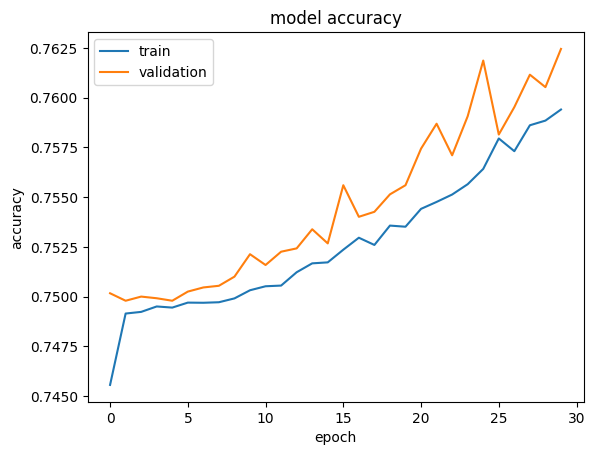

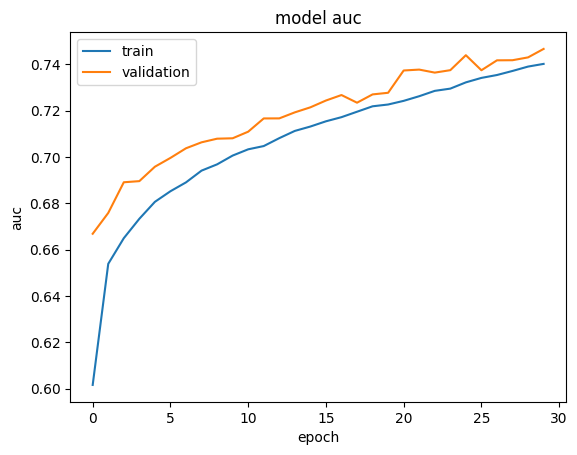

4/4 [==============================] - 1s 56ms/step


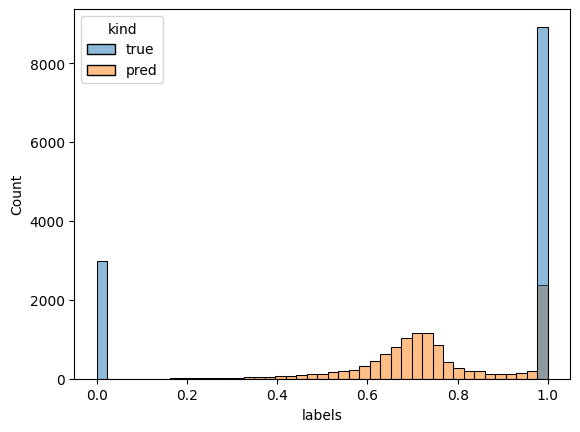

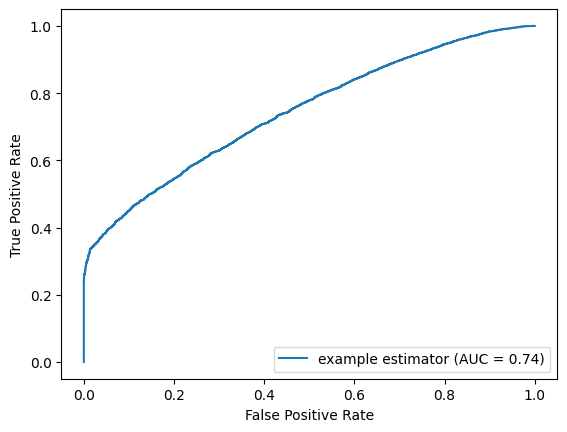

Confusion Matrix con threshold 0.5


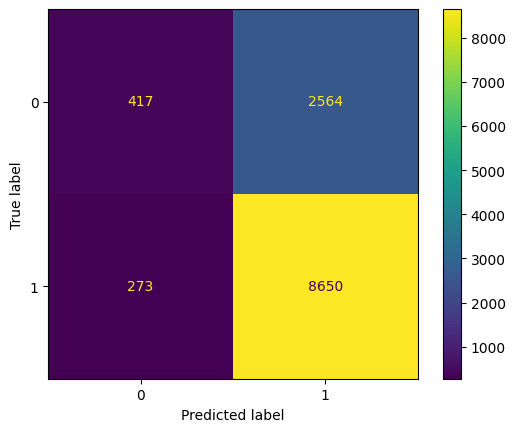

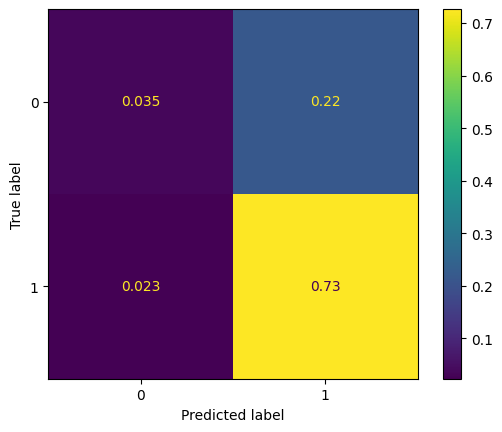

0.7551714
Confusion Matrix con threshold: 0.7551714181900024


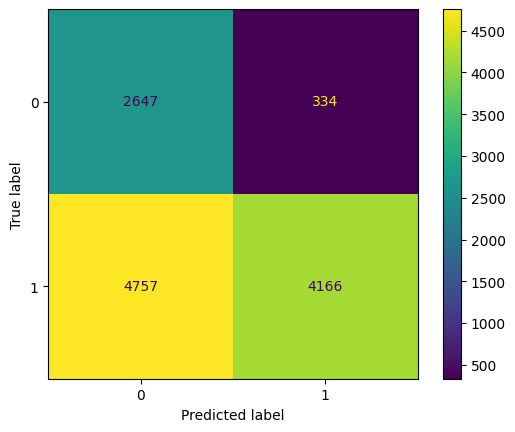

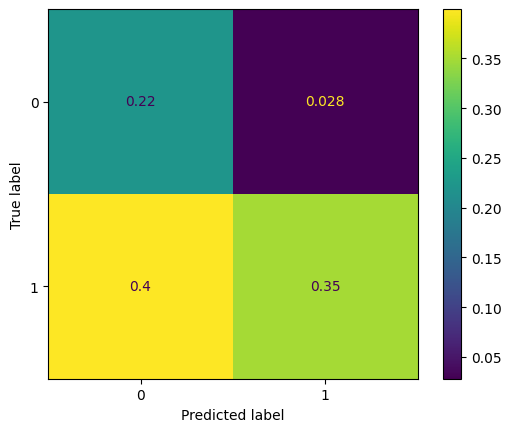

Guardando archivos en /content/drive/MyDrive/tpp/Colab/comparaciones/output/comparacion-hiperparametros-epochs30/005
       loss  accuracy       auc  val_loss  val_accuracy   val_auc      lr
0  0.545414  0.745560  0.601577  0.517874      0.750167  0.666839  0.0001
1  0.519248  0.749148  0.653858  0.510540      0.749791  0.675832  0.0001
2  0.512978  0.749231  0.664929  0.502849      0.750000  0.689070  0.0001
3  0.508554  0.749504  0.673305  0.501945      0.749916  0.689560  0.0001
4  0.504739  0.749447  0.680621  0.498279      0.749791  0.695781  0.0001
4/4 [==============================] - 1s 57ms/step
   y_true    y_pred
0       1  0.725154
1       0  0.639805
2       0  0.812534
3       1  0.710091
4       1  1.000000
Scores
{'model': 'DenseNet121', 'wauc': 0.8152353734154819, 'auc': 0.7442030450505138}


In [ ]:
def build_datasets(filenames, batch_size, is_test, img_size, preprocess_input, channel):
  train_dataset = new_dataset(filenames['train'], batch_size, img_size, preprocess_input, shuffle=True, augmentation=True, channel=channel)
  val_dataset = new_dataset(filenames['val'], batch_size, img_size, preprocess_input, channel)
  test_dataset = new_dataset(filenames['test'], batch_size, img_size, preprocess_input, channel)

  if is_test:
    train_dataset = train_dataset.take(3)
    val_dataset = val_dataset.take(1)
    test_dataset = test_dataset.take(1)

  datasets = {
      'train': train_dataset,
      'val': val_dataset,
      'test': test_dataset
  }
  return datasets

def test_models(strategy, hyperparams, cnn_descriptions, filenames, epochs, is_test, output_path, start=0, save_model=True):
  res = []
  for test_number, hyperparam in enumerate(hyperparams):
    if test_number < start:
      continue

    cnn_name = hyperparam['cnn_name']
    test_as_str = f'{test_number:03}'
    print(f"Revisando: {cnn_name}")
    print(f"test_number: {test_as_str} / {len(hyperparams)}")
    print(f"hyperparam: {hyperparam}")
    cnn = cnn_descriptions[cnn_name]
    print(cnn)
    batch_size = strategy.num_replicas_in_sync * cnn.get('batch_factor', 16)
    print(f'Batch size: {batch_size}')
    datasets = build_datasets(filenames, batch_size , is_test, cnn['img_size'], cnn['preprocess_input'], hyperparam['channel'])

    model = build_model(strategy, cnn, hyperparam)
    #model.summary()

    # Reduce Learning Rate
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
      monitor='val_loss',
      factor=0.5,
      patience=5,
      min_lr=1e-6
    )

    # Save best model
    path = Path(output_path, test_as_str)
    path.mkdir(parents=True, exist_ok=True)
    checkpoint_filepath = str(Path(path, 'model.h5'))
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath
    )

    callbacks = [reduce_lr]
    if save_model:
      callbacks.append(model_checkpoint_callback)

    history = model.fit(
      datasets['train'],
      epochs=epochs,
      validation_data=datasets['val'],
      callbacks=callbacks
    )
    plot_model(model, datasets['test'], history)

    model_postprocess(test_as_str, hyperparam, cnn, model, datasets['test'], history, output_path)
    res.append({
        'model': model,
        'test_number': test_number,
        'test_dataset': datasets['test'],
        'val_dataset': datasets['val']
    })
  return res

res = test_models(
    strategy,
    hyperparams,
    CNN_MODELS,
    filenames,
    EPOCHS,
    IS_TEST,
    OUTPUT_PATH,
    start=5,
    save_model=True
)

In [ ]:
model = res[0]['model']
test_dataset = res[0]['test_dataset']
val_dataset = res[0]['val_dataset']

In [ ]:
model.evaluate(test_dataset)

93/93 [==============================] - 16s 154ms/step - loss: 0.4677 - accuracy: 0.7618 - auc: 0.7449


[0.4676707983016968, 0.7617607712745667, 0.7449212074279785]

In [ ]:
y_pred = model.predict(test_dataset).flatten()
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

93/93 [==============================] - 29s 154ms/step


In [ ]:
y_pred[:10]

array([0.7360475 , 0.68768495, 0.8532719 , 0.7631842 , 0.66075087,
       0.6671355 , 0.9999999 , 0.89961267, 0.97603685, 0.6635039 ],
      dtype=float32)

In [ ]:
y_true[:10]

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1])

In [ ]:
alaska_weighted_auc(y_true, y_pred)

0.5821954163191322

In [ ]:
roc_auc_score(y_true, y_pred)

0.5012096060595335

In [ ]:
data = {
    'y_true': [],
    'y_pred': []

}
for images, labels in test_dataset:
    preds = model.predict(images)
    data['y_true'].extend(labels.numpy())
    data['y_pred'].extend(preds.flatten())

print(data)

4/4 [==============================] - 1s 56ms/step
{'y_true': [1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 

In [ ]:
roc_auc_score(data['y_true'], data['y_pred'])

0.744360386312629

In [ ]:
alaska_weighted_auc(data['y_true'], data['y_pred'])

0.815338209170913